# Classificação com Árvores de Decisão e Random Forest usando Pipeline

In [1]:
# Importação de bibliotecas
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns


path = "/content/drive/MyDrive/ml-project/data" #pasta do projeto
FILE = "smart-contract-dataset.csv" #nome do arquivo
SEED = 78 #seed para usar nas divisões de dados
CV_FOLDS = 5 #folds para cross validation
SCORING_METRIC = 'precision' #qual estimativa priorizar


## Carregamento dos dados (substitua pelo seu dataset)

In [2]:
data = pd.read_csv(os.path.join(FILE)) #carrega os dados

X = data.iloc[:, 3:].select_dtypes(include="number") #filtra as linhas numéricas a partir da col índex 3
y = data.label #filtra todas as linhas da coluna "label"

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

## Pipeline com Decision Tree priorizando o Recall

Melhores parâmetros para Decision Tree: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      5410
           1       0.51      0.51      0.51      1925

    accuracy                           0.74      7335
   macro avg       0.67      0.67      0.67      7335
weighted avg       0.74      0.74      0.74      7335



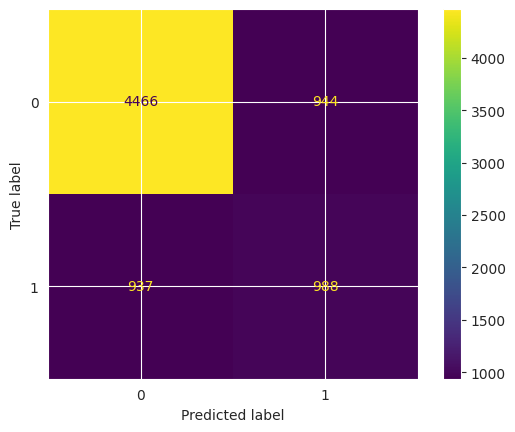

In [3]:
# Pipeline com Decision Tree e busca por hiperparâmetros que maximizem o recall
dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=SEED))
])

# Definindo a grade de parâmetros para busca
dt_param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [3, 5, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(dt_pipeline, dt_param_grid, scoring='recall', cv=5, n_jobs=-1)
dt_grid.fit(X_train, y_train)

# Avaliação
print("Melhores parâmetros para Decision Tree:", dt_grid.best_params_)
y_pred = dt_grid.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


## Pipeline com Random Forest priorizando o Recall

Melhores parâmetros para Random Forest: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88      5410
           1       0.72      0.43      0.54      1925

    accuracy                           0.81      7335
   macro avg       0.77      0.68      0.71      7335
weighted avg       0.79      0.81      0.79      7335



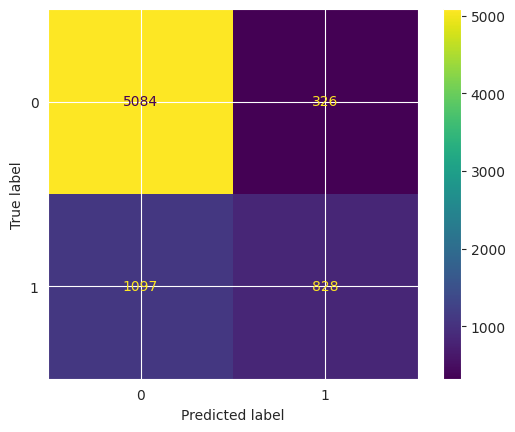

In [4]:
# Pipeline com Random Forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])

# Grade de parâmetros para Random Forest
rf_param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, scoring='recall', cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)

# Avaliação
print("Melhores parâmetros para Random Forest:", rf_grid.best_params_)
y_pred_rf = rf_grid.predict(X_test)
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.show()


## Aplicando PCA antes dos classificadores

In [5]:
# PCA com 70% da variância explicada
pca = PCA(n_components=0.70)
X_train_pca = pca.fit_transform(StandardScaler().fit_transform(X_train))
X_test_pca = pca.transform(StandardScaler().fit_transform(X_test))

print("Número de componentes após PCA:", X_train_pca.shape[1])


Número de componentes após PCA: 42


## Decision Tree após PCA

In [ ]:
# Treinamento com PCA + Decision Tree
dt_pca_pipeline = Pipeline([
    ('clf', DecisionTreeClassifier(random_state=42))
])

dt_grid_pca = GridSearchCV(dt_pca_pipeline, {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [3, 5, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}, scoring='recall', cv=5, n_jobs=-1)

dt_grid_pca.fit(X_train_pca, y_train)

print("Melhores parâmetros DT com PCA:", dt_grid_pca.best_params_)
y_pred_pca_dt = dt_grid_pca.predict(X_test_pca)
print(classification_report(y_test, y_pred_pca_dt))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pca_dt, cmap="Blues")
plt.show()


## Random Forest após PCA

Melhores parâmetros RF com PCA: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 50}
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      5410
           1       0.66      0.27      0.38      1925

    accuracy                           0.77      7335
   macro avg       0.72      0.61      0.62      7335
weighted avg       0.75      0.77      0.73      7335



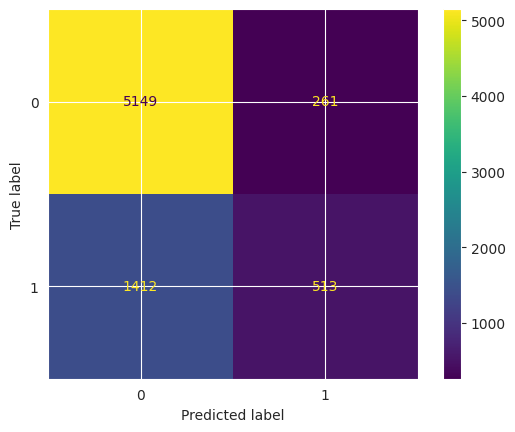

In [7]:
rf_pca_pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

rf_grid_pca = GridSearchCV(rf_pca_pipeline, {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}, scoring='recall', cv=5, n_jobs=-1)

rf_grid_pca.fit(X_train_pca, y_train)

print("Melhores parâmetros RF com PCA:", rf_grid_pca.best_params_)
y_pred_pca_rf = rf_grid_pca.predict(X_test_pca)
print(classification_report(y_test, y_pred_pca_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_pca_rf, cmap="Blues")
plt.show()
